In [1]:
# ==== SECTION 0: Imports & Paths ====
import os, re, glob, csv
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Configure matplotlib for Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random as jr, jit, vmap, grad

import wandb
import optax

print("JAX devices:", jax.devices())
print("JAX default backend:", jax.default_backend())

SEED = 42
RNG = jr.PRNGKey(SEED)

# Paths
BRA_TS_DIR = "../data/BraTS-2023"
MU_DIR     = "../data/MU-Glioma-Post"
CKPT_DIR   = "../checkpoints"
ART_DIR    = "../artifacts"

for d in [CKPT_DIR, ART_DIR]:
    os.makedirs(d, exist_ok=True)

# W&B Configuration
WANDB_PROJECT = "brats-inr-segmentation"
WANDB_RUN_NAME = "notebook-training"

wandb.init(project=WANDB_PROJECT, name=WANDB_RUN_NAME)

JAX devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11)]
JAX default backend: cpu


wandb: Currently logged in as: kylelukaszek (kylelukaszek-university-of-guelph) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# ==== SECTION 1: Build BraTS manifest ====
root = BRA_TS_DIR
cases = sorted([p for p in glob.glob(os.path.join(root, "*")) if os.path.isdir(p)])

def pick(files, pattern):
    rx = re.compile(pattern, re.I)
    for f in files:
        if rx.search(os.path.basename(f)):
            return f
    return ""

rows = []
for case in cases:
    files = glob.glob(os.path.join(case, "*.nii*"))
    rows.append({
        "id":   os.path.basename(case),
        "t1":   pick(files, r"t1n|t1\.nii"),
        "t1ce": pick(files, r"t1c|t1ce"),
        "t2":   pick(files, r"t2(?!f)|t2w"),
        "flair":pick(files, r"t2f|flair"),
        "mask": pick(files, r"seg|mask")
    })

man_bra = os.path.join(BRA_TS_DIR, "manifest.csv")
with open(man_bra, "w", newline="") as fp:
    w = csv.DictWriter(fp, fieldnames=["id","t1","t1ce","t2","flair","mask"])
    w.writeheader(); w.writerows(rows)

print(f"Wrote {len(rows)} rows -> {man_bra}")


Wrote 1251 rows -> ../data/BraTS-2023/manifest.csv


In [3]:
import os
import glob
import csv
import re
from typing import List

def pick(files: List[str], pattern: str, flags=re.IGNORECASE) -> str:
    """Return first file matching pattern (on basename). Returns empty string if none."""
    rx = re.compile(pattern, flags)
    for f in files:
        name = os.path.basename(f)
        if rx.search(name):
            return os.path.relpath(f, root)
    return ""

# Auto-detect correct root if dataset is nested (e.g., MU-Glioma-Post/MU-Glioma-Post/...)
root = MU_DIR
patients = sorted([p for p in glob.glob(os.path.join(root, "PatientID_*")) if os.path.isdir(p)])
if not patients:
    # look one level deeper for a folder that looks like the dataset (name starts with MU- or similar)
    candidates = [d for d in glob.glob(os.path.join(MU_DIR, "*")) if os.path.isdir(d) and os.path.basename(d).lower().startswith("mu")]
    if candidates:
        root = candidates[0]
        patients = sorted([p for p in glob.glob(os.path.join(root, "PatientID_*")) if os.path.isdir(p)])

rows = []
for pat_dir in patients:
    tps = sorted([tp for tp in glob.glob(os.path.join(pat_dir, "Timepoint_*")) if os.path.isdir(tp)])
    for tp in tps:
        files = glob.glob(os.path.join(tp, "**", "*.nii*"), recursive=True)
        row = {
            "id":   os.path.relpath(tp, root).replace(os.sep, "_"),
            "t1":   pick(files, r"(^|[^a-z0-9])t1(_n|n?1)?(\.|_|$)"),
            "t1ce": pick(files, r"t1c|t1ce"),
            "t2":   pick(files, r"(^|[^a-z0-9])t2(?!f)(\.|_|$)|t2w"),
            "flair":pick(files, r"t2f|flair"),
            "mask": pick(files, r"seg|mask|tumorMask|_seg")
        }
        rows.append(row)

man_mu = os.path.join(MU_DIR, "manifest.csv")
with open(man_mu, "w", newline="") as fp:
    w = csv.DictWriter(fp, fieldnames=["id","t1","t1ce","t2","flair","mask"])
    w.writeheader(); w.writerows(rows)

print(f"Root used: {root}")
print(f"Wrote {len(rows)} rows -> {man_mu}")
if len(rows) == 0:
    print("Warning: no timepoints found. Check that patient and Timepoint_* directories contain .nii/.nii.gz files.")

Root used: ../data/MU-Glioma-Post/MU-Glioma-Post
Wrote 596 rows -> ../data/MU-Glioma-Post/manifest.csv


In [4]:
# ==== SECTION 3: Train/Val split for BraTS ====
MAX_CASES = 1251

rng_key = jr.split(RNG)[0]
with open(man_bra) as fp:
    all_rows = [r for r in csv.DictReader(fp) if all(r.get(k) for k in ["t1","t1ce","t2","flair","mask"])]

perm = jr.permutation(rng_key, jnp.arange(len(all_rows)))
all_rows = [all_rows[int(i)] for i in perm]
all_rows = all_rows[:MAX_CASES]

n_total = len(all_rows)
n_val = int(0.2 * n_total)
val_rows = all_rows[:n_val]
train_rows = all_rows[n_val:]

def write_rows(rows, path):
    with open(path, "w", newline="") as fp:
        w = csv.DictWriter(fp, fieldnames=["id","t1","t1ce","t2","flair","mask"])
        w.writeheader(); w.writerows(rows)

train_csv = os.path.join(BRA_TS_DIR, "train.csv")
val_csv   = os.path.join(BRA_TS_DIR, "val.csv")
write_rows(train_rows, train_csv)
write_rows(val_rows, val_csv)

print(f"Train: {len(train_rows)} | Val: {len(val_rows)}")

# Log CSVs to W&B
artifact = wandb.Artifact("dataset-splits", type="dataset")
artifact.add_file(train_csv)
artifact.add_file(val_csv)
wandb.log_artifact(artifact)

Train: 1001 | Val: 250


<Artifact dataset-splits>

In [5]:
# ==== CONFIG: INR architecture, optimizer, and sampling ====

import wandb

# High-level hyperparameters for this run
INR_CONFIG = {
    # SIREN architecture
    'hidden_dims': [256, 256],
    'w0': 30.0,
    # Optimizer (Optax Muon)
    'optimizer': 'muon',
    'learning_rate': 2e-3,
    # Training sampling / schedule
    'epochs_target': 3,
    'points_per_slice': 32768 * 3,
    'val_monitor_cases': 2,
    'val_monitor_points': 4096,
}

# Update W&B config so runs are comparable and sweepable
try:
    wandb.config.update(INR_CONFIG, allow_val_change=True)
except Exception as e:
    print(f"W&B config update skipped/failed: {e}")

print("INR/optimizer/sampling config:")
for k, v in INR_CONFIG.items():
    print(f"  {k}: {v}")


INR/optimizer/sampling config:
  hidden_dims: [256, 256]
  w0: 30.0
  optimizer: muon
  learning_rate: 0.002
  epochs_target: 3
  points_per_slice: 98304
  val_monitor_cases: 2
  val_monitor_points: 4096


In [6]:
# ==== SECTION 4: Data Loading (memory-optimized) ====
def _load_nifti_slice(path, z_idx=None, dtype=np.float32):
    """Load either a full volume or a single Z slice using the array proxy to avoid unnecessary copies."""
    img = nib.load(path)
    if z_idx is None:
        arr = np.asarray(img.dataobj, dtype=dtype)
    else:
        # Use slicing on the dataobj to only read one slice into memory
        arr = np.asarray(img.dataobj[..., int(z_idx)], dtype=dtype)
    return arr

def load_modalities(row):
    "Return full volume as float32 modalities and uint8 mask (preserve labels)."""
    vols = []
    for k in ["t1", "t1ce", "t2", "flair"]:
        p = row[k]
        arr = _load_nifti_slice(p, z_idx=None, dtype=np.float32)
        # normalize per-volume (float32) -- keep small eps for stability
        arr = (arr - arr.mean()) / (arr.std() + 1e-6)
        vols.append(jnp.array(arr, dtype=jnp.float32))
    vol = jnp.stack(vols, axis=0)  # [C, X, Y, Z]
    # Load mask as uint8 and preserve segmentation labels (0,1,2,4 etc.)
    mask_arr = _load_nifti_slice(row["mask"], z_idx=None, dtype=np.uint8)
    mask = jnp.array(mask_arr, dtype=jnp.uint8)
    return vol, mask

def build_indexed_slices(manifest_path, max_slices_per_case=8, background_drop=0.7, seed=0):
    "Build a lightweight index of (row, z, z_norm) pairs. Slices are loaded on-demand at batch time."""
    rng = np.random.RandomState(int(SEED) + int(seed))
    with open(manifest_path) as fp:
        rows = list(csv.DictReader(fp))
    index_list = []
    for row in rows:
        # probe z from one modality (assumes modalities share spatial dims)
        p = row['t1']
        img = nib.load(p)
        z = img.shape[-1]
        idxs = np.linspace(0, z - 1, num=min(max_slices_per_case, z), dtype=int)
        for iz in idxs:
            # check background for this slice by reading only the mask slice
            mask_slice = np.asarray(nib.load(row['mask']).dataobj[..., int(iz)], dtype=np.uint8)
            is_bg = (mask_slice.sum() == 0)
            # optionally drop some background slices
            if is_bg and rng.rand() < background_drop:
                continue
            # normalized z in [-1,1] (handle degenerate single-slice volumes)
            if img.shape[-1] > 1:
                z_norm = float( (float(iz) / float(img.shape[-1] - 1)) * 2.0 - 1.0 )
            else:
                z_norm = 0.0
            index_list.append({'row': row, 'z': int(iz), 'z_norm': z_norm})
    return index_list

def batch_generator(index_list, batch_size=8, shuffle=True, loop_forever=False):
    "Yield batches of (X, Y, Zs) where X=[B, C, H, W], Y=[B, H, W] and Zs=[B] (normalized z floats). Loads data per-slice on demand."""
    n = len(index_list)
    order = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(order)
        for start in range(0, n, batch_size):
            batch_idx = order[start:start + batch_size]
            Xb = []
            Yb = []
            Zb = []
            for i in batch_idx:
                entry = index_list[int(i)]
                row = entry['row']
                z = entry['z']
                z_norm = entry.get('z_norm', 0.0)
                # load 2D slice for each modality (float32)
                slices = []
                for k in ["t1", "t1ce", "t2", "flair"]:
                    sl = _load_nifti_slice(row[k], z_idx=z, dtype=np.float32)
                    # per-slice normalization (keeps contrast comparable across slices)
                    sl = (sl - sl.mean()) / (sl.std() + 1e-6)
                    slices.append(sl)
                X = np.stack(slices, axis=0)  # [C, H, W]
                mask_sl = np.asarray(nib.load(row['mask']).dataobj[..., z], dtype=np.uint8)
                Xb.append(X)
                Yb.append(mask_sl)
                Zb.append(z_norm)
            # convert to JAX arrays and put on device when consumed
            Xb = jnp.array(np.stack(Xb, axis=0), dtype=jnp.float32)
            Yb = jnp.array(np.stack(Yb, axis=0), dtype=jnp.uint8)
            Zb = jnp.array(Zb, dtype=jnp.float32)
            yield Xb, Yb, Zb
        if not loop_forever:
            break

# Build lightweight index (no full-volume allocations) and expose a batch generator
train_index = build_indexed_slices(train_csv, max_slices_per_case=8, background_drop=0.7, seed=0)
val_index = build_indexed_slices(val_csv, max_slices_per_case=8, background_drop=0.7, seed=1)

print(f"Index built: train={len(train_index)} | val={len(val_index)}")


Index built: train=4458 | val=1130


In [7]:
# ==== DIAGNOSTIC: Verify we're training on all data ====
print("=" * 60)
print("DATA LOADING VERIFICATION")
print("=" * 60)
print(f"\nTrain index size: {len(train_index)} (total slices after background dropping)")
print(f"Val index size: {len(val_index)} (total slices after background dropping)")

# Calculate batch coverage
batch_size = 16  # from prefetch_train setup
num_batches_per_epoch = len(train_index) // batch_size
remainder = len(train_index) % batch_size

print(f"\nBatch size: {batch_size}")
print(f"Batches per full epoch: {num_batches_per_epoch}")
print(f"Samples in final partial batch: {remainder}")
print(f"Total samples that fit in batches: {num_batches_per_epoch * batch_size}")

# Updated: target 3 full epochs of training
epochs_target = 3
max_steps = num_batches_per_epoch * epochs_target
total_training_samples_used = max_steps * batch_size

print(f"\nTarget epochs: {epochs_target}")
print(f"Max steps (computed): {max_steps}")
print(f"Total training samples used (steps * batch_size): {total_training_samples_used}")
print(f"Epochs covered: {total_training_samples_used / len(train_index):.2f}")

# K-fold validation frequency
val_every = num_batches_per_epoch // 2  # evaluate 2x per epoch
print(f"\nK-fold validation every {val_every} steps (2x per epoch)")

if len(train_index) == 0:
    print(f"\n⚠️  ERROR: No training samples! Index is empty.")
else:
    print(f"\n✓ Training will cover the FULL dataset {epochs_target}x")
print("=" * 60)


DATA LOADING VERIFICATION

Train index size: 4458 (total slices after background dropping)
Val index size: 1130 (total slices after background dropping)

Batch size: 16
Batches per full epoch: 278
Samples in final partial batch: 10
Total samples that fit in batches: 4448

Target epochs: 3
Max steps (computed): 834
Total training samples used (steps * batch_size): 13344
Epochs covered: 2.99

K-fold validation every 139 steps (2x per epoch)

✓ Training will cover the FULL dataset 3x


# ==== Interactive Data Visualization ====

In [8]:
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import nibabel as nib

import matplotlib.pyplot as plt

def load_full_modalities(row):
    """Load full modalities using memory-efficient proxy reads and return float32 modalities + uint8 mask."""
    vols = []
    for k in ["t1", "t1ce", "t2", "flair"]:
        arr = np.asarray(nib.load(row[k]).dataobj, dtype=np.float32)
        arr = (arr - arr.mean()) / (arr.std() + 1e-6)
        vols.append(jnp.array(arr, dtype=jnp.float32))
    vol = jnp.stack(vols, axis=0)  # [C, X, Y, Z]
    mask = jnp.array(np.asarray(nib.load(row['mask']).dataobj, dtype=np.uint8), dtype=jnp.uint8)
    return vol, mask

# Load rows
train_rows = list(csv.DictReader(open(train_csv)))
val_rows = list(csv.DictReader(open(val_csv)))

case_widget = widgets.Select(description='Case:' )
dataset_widget = widgets.ToggleButtons(options=['train', 'val'], description='Dataset:' )
slice_widget = widgets.IntSlider(description='Slice:', min=0, max=100, value=50 )
save_button = widgets.Button(description='Save to W&B')
# Layout: improve spacing and margins; set fixed widths to avoid wrapping
case_widget.layout = widgets.Layout(width='260px')
dataset_widget.layout = widgets.Layout(width='140px')
dataset_widget.style.button_width = '80px'
dataset_widget.layout.justify_content = 'flex-start'
slice_widget.layout = widgets.Layout(width='420px')
slice_widget.continuous_update = True
save_button.layout.margin = '0px 0px 0px 8px'
controls_box = widgets.HBox([case_widget, dataset_widget, slice_widget, save_button], layout=widgets.Layout(display='flex', flex_flow='row', align_items='center', padding='6px', margin='6px 0px 6px 0px', gap='8px'))

current_fig = None

def update_cases(change):
    if dataset_widget.value == 'train':
        cases = [r['id'] for r in train_rows]
    else:
        cases = [r['id'] for r in val_rows]
    case_widget.options = cases
    if cases:
        case_widget.value = cases[0]

def update_slice(change):
    if dataset_widget.value == 'train':
        rows = train_rows
    else:
        rows = val_rows
    if rows:
        row = next(r for r in rows if r['id'] == case_widget.value)
        vol, _ = load_full_modalities(row)
        max_slice = vol.shape[-1] - 1
        slice_widget.max = max_slice
        slice_widget.value = max_slice // 2

def save_to_wandb(b):
    global current_fig
    if current_fig:
        wandb.log({"interactive_plot": wandb.Image(current_fig)})
        print("Saved plot to W&B")

save_button.on_click(save_to_wandb)

dataset_widget.observe(update_cases, names='value')
case_widget.observe(update_slice, names='value')
update_cases(None)
update_slice(None)

def plot_case(dataset, case_id, slice_idx):
    global current_fig
    if dataset == 'train':
        rows = train_rows
    else:
        rows = val_rows
    row = next(r for r in rows if r['id'] == case_id)
    vol, mask = load_full_modalities(row)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    modalities = ['T1', 'T1ce', 'T2', 'FLAIR']
    for i in range(4):
        axes[i].imshow(vol[i, :, :, slice_idx], cmap='gray')
        colored_mask = jnp.zeros((*mask.shape[:2], 3))
        colored_mask = colored_mask.at[mask[:, :, slice_idx] == 1].set(jnp.array([1, 0, 0]))  # red: necrotic
        colored_mask = colored_mask.at[mask[:, :, slice_idx] == 2].set(jnp.array([0, 1, 0]))  # green: edema
        colored_mask = colored_mask.at[mask[:, :, slice_idx] == 4].set(jnp.array([0, 0, 1]))  # blue: enhancing
        axes[i].imshow(colored_mask, alpha=0.5)
        axes[i].set_title(modalities[i])
    current_fig = fig
    plt.show()

output = widgets.interactive_output(plot_case, {'dataset': dataset_widget, 'case_id': case_widget, 'slice_idx': slice_widget})

# Wrap output in a box to control padding
output_box = widgets.VBox([output], layout=widgets.Layout(padding='6px', margin='0px'))
display(widgets.VBox([controls_box, output_box], layout=widgets.Layout(padding='4px')) )

In [9]:
# ==== SECTION 5: Prefetch + device-transfer helper ====
from queue import Queue
from threading import Thread
import jax

def prefetch_generator(generator, max_prefetch=8, device=None):
    """Wrap a Python generator with a background thread that prefetches items into a queue.

    - `generator` yields (X, Y, Zs) where X/Y are JAX arrays or numpy arrays and Zs is per-sample normalized z.
    - `max_prefetch` controls queue depth (useful for keeping the accelerator busy).
    - `device` (optional) is a `jax.Device` to transfer batches to (e.g., `jax.devices()[0]`).

    Notes:
    - Uses a daemon thread so the notebook can exit cleanly.
    - For reproducible multi-worker setups consider using multiprocessing-aware designs.
    """
    q = Queue(max_prefetch)
    sentinel = object()

    def _worker():
        try:
            for item in generator:
                q.put(item)
        finally:
            q.put(sentinel)

    t = Thread(target=_worker, daemon=True)
    t.start()

    while True:
        item = q.get()
        if item is sentinel:
            break
        X, Y, Zs = item
        if device is not None:
            X = jax.device_put(X, device=device)
            Y = jax.device_put(Y, device=device)
            Zs = jax.device_put(Zs, device=device)
        yield X, Y, Zs

# Example: create a prefetched training generator using available resources
# We have 12 cores and ~24GB RAM; a prefetch depth of 8-16 is a reasonable starting point.
train_gen = batch_generator(train_index, batch_size=12, shuffle=True, loop_forever=True)
prefetch_train = prefetch_generator(train_gen, max_prefetch=12, device=jax.devices()[0])

# Pull a single batch to sanity-check shapes
Xb, Yb, Zb = next(prefetch_train)
print('Prefetch batch shapes:', Xb.shape, Yb.shape, Zb.shape, Xb.dtype, Yb.dtype)


Prefetch batch shapes: (12, 4, 240, 240) (12, 240, 240) (12,) float32 uint8


In [10]:
# ==== SECTION 6: JIT & PMAP-friendly helpers ====
import math
from functools import partial
import jax
import jax.numpy as jnp
from jax import jit

n_devices = jax.device_count()

@jit
def preprocess_batch_jit(X, Y):
    """JIT-able preprocessing for a batch.

    - X: [B, C, H, W] (numeric)
    - Y: [B, H, W] (labels)

    Normalizes X per-sample and per-channel, clamps values, and ensures dtypes.
    Returns jnp arrays with dtypes (float32, uint8).
    """
    X = jnp.asarray(X, dtype=jnp.float32)
    # per-sample, per-channel normalization across spatial dims
    mean = jnp.mean(X, axis=(2, 3), keepdims=True)
    std = jnp.std(X, axis=(2, 3), keepdims=True) + 1e-6
    X = (X - mean) / std
    X = jnp.clip(X, -5.0, 5.0)
    Y = jnp.asarray(Y, dtype=jnp.uint8)
    return X, Y


def shard_batch(X, Y, n_dev=None):
    """Split a batch into `n_dev` shards for `pmap` / device_put_sharded.

    - X: [B, C, H, W]
    - Y: [B, H, W]

    Returns two lists of length `n_dev` with per-device arrays.
    """
    if n_dev is None:
        n_dev = jax.device_count()
    B = X.shape[0]
    if B % n_dev != 0:
        raise ValueError(f"Batch size {B} not divisible by n_devices {n_dev}")
    per = B // n_dev
    # reshape into (n_dev, per, ...)
    Xs = jnp.reshape(jnp.asarray(X), (n_dev, per) + X.shape[1:])
    Ys = jnp.reshape(jnp.asarray(Y), (n_dev, per) + Y.shape[1:])
    # convert to Python list of arrays for device_put_sharded
    X_list = [Xs[i] for i in range(n_dev)]
    Y_list = [Ys[i] for i in range(n_dev)]
    return X_list, Y_list


def device_put_sharded_batch(X, Y, devices=None):
    """Transfer a batch to devices as sharded arrays suitable for `pmap`.

    - devices: list of jax.Device or None (defaults to all local devices)
    - Returns: (X_sharded, Y_sharded) where each is a ShardedDeviceArray
    """
    if devices is None:
        devices = jax.devices()
    n_dev = len(devices)
    X_list, Y_list = shard_batch(X, Y, n_dev=n_dev)
    X_sharded = jax.device_put_sharded(X_list, devices)
    Y_sharded = jax.device_put_sharded(Y_list, devices)
    return X_sharded, Y_sharded


# Example jittable single-device training step (skeleton)
def train_step_single(fn_apply, params, X, Y):
    """Example: single-device jitted training step stub.

    - fn_apply: model forward (params, X) -> logits
    - params: model parameters
    - X: [B, C, H, W] float32
    - Y: [B, H, W] uint8

    This function is intentionally minimal — replace with your optimizer/update logic.
    """
    logits = fn_apply(params, X)
    # Example loss (mean squared) — replace with appropriate segmentation loss
    loss = jnp.mean((logits - Y.astype(jnp.float32)) ** 2)
    return loss

# Wrap with jit and mark fn_apply static (it's a Python callable)
train_step_single = jit(train_step_single, static_argnames=('fn_apply',))


# pmap-ready wrapper: make sure the single-device fn is pmapped across devices
p_train_step = jax.pmap(train_step_single, axis_name='batch')

# Small usage example (sanity-check). This will only run if a prefetched batch exists.
try:
    Xb, Yb, Zb = next(prefetch_train)
    # Preprocess (runs on CPU until jitted is called)
    Xb_proc, Yb_proc = preprocess_batch_jit(Xb, Yb)
    # Make sharded arrays and transfer to devices
    X_sharded, Y_sharded = device_put_sharded_batch(Xb_proc, Yb_proc)
    print('Prepared sharded batch:', X_sharded.shape, Y_sharded.shape)
except Exception as e:
    print('Sanity-check skipped (no batch or small mismatch):', e)


Prepared sharded batch: (12, 1, 4, 240, 240) (12, 1, 240, 240)


In [11]:
# Helper functions: build_coords_modalities, mask mapping, dice, prediction, and train_step
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad
import optax


def build_coords_modalities(X, z_indices=None):
    """Build per-pixel coordinate+modality inputs for SIREN/INR.

    Args:
      X: jnp array shaped [S, C, H, W] (C==4: t1,t1ce,t2,flair)
      z_indices: optional 1D array-like of length S (normalized z in [-1,1])

    Returns:
      inputs: jnp array shaped [S*H*W, 7] with columns [x, y, z_norm, t1, t1ce, t2, flair]
    """
    X = jnp.asarray(X)
    if X.ndim != 4:
        raise ValueError(f"Expected X with 4 dims [S,C,H,W], got {X.shape}")
    S, C, H, W = X.shape
    if C != 4:
        raise ValueError(f"Expected 4 modalities (C==4), got C={C}")

    # normalized x,y in [-1,1]
    xs = jnp.linspace(-1.0, 1.0, W, dtype=jnp.float32)
    ys = jnp.linspace(-1.0, 1.0, H, dtype=jnp.float32)
    gx, gy = jnp.meshgrid(xs, ys)  # shapes [H, W]
    gx_f = gx.reshape(-1)
    gy_f = gy.reshape(-1)

    # modalities: reshape each slice to [S, H*W, C]
    X_resh = jnp.transpose(X, (0, 2, 3, 1))  # [S, H, W, C]
    X_flat = X_resh.reshape(S, H * W, C)     # [S, H*W, C]

    # z_indices handling
    if z_indices is None:
        z_arr = jnp.zeros((S,), dtype=jnp.float32)
    else:
        z_arr = jnp.asarray(z_indices, dtype=jnp.float32)
        if z_arr.ndim == 0:
            z_arr = jnp.full((S,), float(z_arr), dtype=jnp.float32)
        elif z_arr.shape[0] != S:
            raise ValueError(f"z_indices length {z_arr.shape[0]} != S {S}")

    coords_xy = jnp.stack([gx_f, gy_f], axis=-1)  # [H*W, 2]
    coords_xy_b = jnp.broadcast_to(coords_xy[None, ...], (S, coords_xy.shape[0], 2))
    z_col = z_arr[:, None]
    z_b = jnp.broadcast_to(z_col[:, None, :], (S, coords_xy.shape[0], 1))  # [S, H*W, 1]

    # Concatenate coords and modalities -> [S, H*W, 3+4]
    inputs_per = jnp.concatenate([coords_xy_b, z_b, X_flat], axis=-1)  # [S, H*W, 7]
    inputs = inputs_per.reshape((-1, inputs_per.shape[-1]))
    return inputs


def map_mask_to_class(mask):
    """Map mask labels to contiguous class ids 0..3.

    Expects mask in {0,1,2,4} (common BraTS labels). Maps 4 -> 3.
    Accepts mask shaped [S,H,W] or [H,W].
    """
    m = jnp.asarray(mask)
    m_mapped = jnp.where(m == 4, 3, m)
    return m_mapped


def dice_per_class(pred_labels, true_labels, num_classes=4, eps=1e-6):
    """Compute Dice per class. Inputs are 1D or flattened  arrays of labels."""
    pred = jnp.asarray(pred_labels).ravel()
    true = jnp.asarray(true_labels).ravel()
    dices = []
    for c in range(num_classes):
        p_c = (pred == c).astype(jnp.float32)
        t_c = (true == c).astype(jnp.float32)
        inter = jnp.sum(p_c * t_c)
        denom = jnp.sum(p_c) + jnp.sum(t_c)
        dice = (2.0 * inter + eps) / (denom + eps)
        dices.append(dice)
    return jnp.stack(dices)


def binary_dice(pred_labels, true_labels, pos_classes=(1,2,3), eps=1e-6):
    """Binary Dice treating any non-background as positive."""
    pred = jnp.asarray(pred_labels).ravel()
    true = jnp.asarray(true_labels).ravel()
    pos = jnp.array(pos_classes)
    pred_pos = jnp.isin(pred, pos).astype(jnp.float32)
    true_pos = jnp.isin(true, pos).astype(jnp.float32)
    inter = jnp.sum(pred_pos * true_pos)
    denom = jnp.sum(pred_pos) + jnp.sum(true_pos)
    return (2.0 * inter + eps) / (denom + eps)


@jit
def predict_mask(params, inputs):
    """Return softmax probabilities for inputs: inputs shape [N, in_dim]."""
    logits = siren_apply(params, inputs)
    return jax.nn.softmax(logits)


def soft_dice_from_probs(probs, targets, num_classes=4, eps=1e-6):
    """Compute soft Dice per class and mean from probabilities.

    Args:
      probs: [N, C] softmax probabilities.
      targets: [N] integer labels.
    Returns:
      (dice_per_class, mean_dice) as JAX arrays.
    """
    one_hot = jax.nn.one_hot(targets, num_classes)
    probs_f = probs.reshape(-1, num_classes)
    oh_f = one_hot.reshape(-1, num_classes)
    inter = jnp.sum(probs_f * oh_f, axis=0)
    denom = jnp.sum(probs_f + oh_f, axis=0)
    dice_per_c = (2.0 * inter + eps) / (denom + eps)
    mean_dice = jnp.mean(dice_per_c)
    return dice_per_c, mean_dice


def soft_dice_loss(logits, targets, num_classes=4, eps=1e-6):
    """Soft Dice loss over all classes.

    Args:
      logits: [N, C] unnormalized scores.
      targets: [N] integer labels.
    Returns:
      scalar soft Dice loss = 1 - mean Dice over classes.
    """
    probs = jax.nn.softmax(logits, axis=-1)
    _, mean_dice = soft_dice_from_probs(probs, targets, num_classes=num_classes, eps=eps)
    return 1.0 - mean_dice


# jitted train step using optax; mark `opt` as static (it's a Python object)
def _train_step_impl(params, opt_state, inputs, targets, num_classes):
    def loss_fn(p, x, y):
        logits = siren_apply(p, x)
        return soft_dice_loss(logits, y, num_classes=num_classes)
    loss, grads = value_and_grad(loss_fn)(params, inputs, targets)
    return loss, grads


def train_step(params, opt_state, inputs, targets, opt):
    # opt must be static when jitted below; num_classes captured from notebook globals
    num_classes = globals().get('num_classes', 4)
    loss, grads = _train_step_impl(params, opt_state, inputs, targets, num_classes)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# JIT the outer train_step and mark `opt` static
train_step = jit(train_step, static_argnames=('opt',))


In [12]:
# ==== SECTION 7: Tiny SIREN INR + Optax Muon training example ====
# Inputs to the INR: (x, y, z) normalized coordinates + 4-modality values -> predict multi-class mask
# This cell builds coordinate+modality inputs, a small SIREN MLP, and a jitted training step

import jax.numpy as jnp
from jax import random, jit, value_and_grad
import optax
import jax

# --- SIREN utilities ---

def siren_init(key, in_dim, hidden_dims, out_dim, w0=30.0):
    keys = random.split(key, len(hidden_dims) + 1)
    params = {}
    dims = [in_dim] + hidden_dims + [out_dim]
    for i in range(len(dims) - 1):
        k = keys[i]
        r = jnp.sqrt(6.0 / dims[i]) / (w0 if i == 0 else 1.0)
        w = random.uniform(k, (dims[i], dims[i+1]), minval=-r, maxval=r)
        b = jnp.zeros((dims[i+1],), dtype=jnp.float32)
        params[f'l{i}'] = {'w': w, 'b': b}
    return params

@jit
def siren_apply(params, x, w0=30.0):
    h = x
    for i in range(len(params) - 1):
        w = params[f'l{i}']['w']
        b = params[f'l{i}']['b']
        if i == 0:
            h = jnp.sin(w0 * (h @ w) + b)
        else:
            h = jnp.sin((h @ w) + b)
    last = params[f'l{len(params)-1}']
    out = (h @ last['w']) + last['b']
    return out

# --- Data helper (already in notebook) ---
# build_coords_modalities, map_mask_to_class, dice_per_class, binary_dice, cross_entropy_logits, predict_mask,
# train_step definitions are expected to exist in previous cells. We will reuse them.

# --- Initialize / optimizer ---
key = random.PRNGKey(SEED)
input_dim = 3 + 4  # xyz + 4 modalities
hidden = [128, 128]
num_classes = 4
class_names = ['background', 'necrotic', 'edema', 'enhancing']
out_dim = num_classes
siren_key, key = random.split(key)
params = siren_init(siren_key, input_dim, hidden, out_dim, w0=30.0)
opt = optax.contrib.muon(learning_rate=1e-3)
opt_state = opt.init(params)

# --- Training & validation configuration ---
points_per_slice = 32768
# max_steps and val_every will be set based on full dataset coverage below
checkpoint_every = 50

In [13]:
# ==== SET TRAINING PARAMETERS FROM DIAGNOSTIC ====
# Override max_steps and val_every with values computed from full dataset coverage
# This ensures we see all training data and validate frequently

batch_size = 12  # Must match prefetch_train batch size
num_batches_per_epoch = len(train_index) // batch_size
epochs_target = 3

max_steps = num_batches_per_epoch * epochs_target
val_every = num_batches_per_epoch // 2  # 2x per epoch

print(f"Training configuration (auto-computed):")
print(f"  Batches per epoch: {num_batches_per_epoch}")
print(f"  Target epochs: {epochs_target}")
print(f"  Max steps: {max_steps}")
print(f"  Val frequency: every {val_every} steps (2x per epoch)")
print(f"  Total coverage: {(max_steps * batch_size) / len(train_index):.2f} epochs")


Training configuration (auto-computed):
  Batches per epoch: 371
  Target epochs: 3
  Max steps: 1113
  Val frequency: every 185 steps (2x per epoch)
  Total coverage: 3.00 epochs


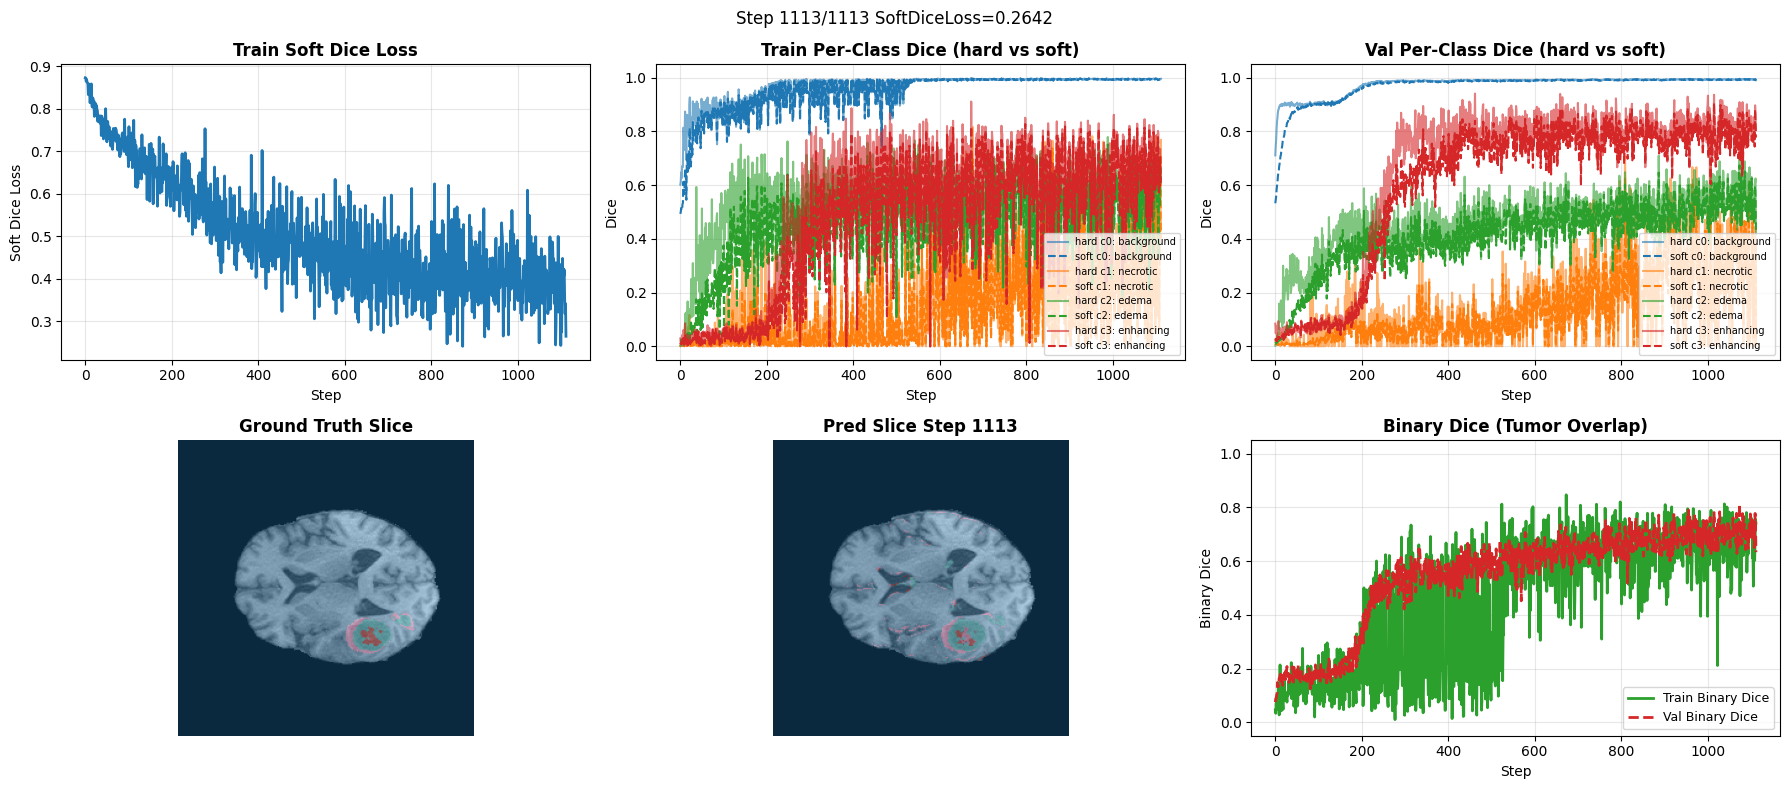

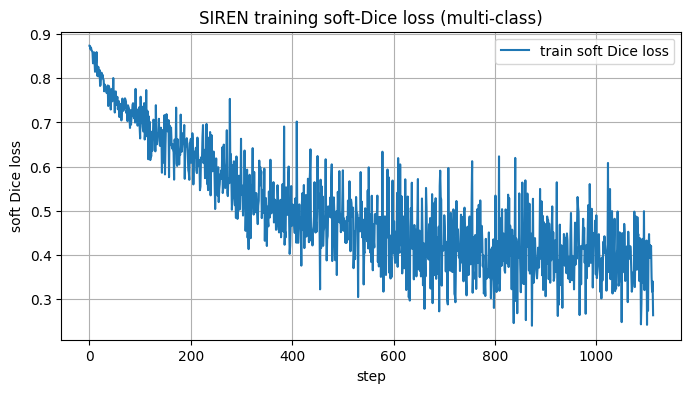


TRAINING COMPLETE
Final step: 1113
Final soft Dice loss: 0.264161
Best soft Dice loss: 0.240466 (at step 874)

Final Train Metrics:
  background: 0.9962
  necrotic: 0.7684
  edema: 0.6598
  enhancing: 0.6230
  Binary Dice: 0.7411

Final Val Metrics:
  background: 0.9907
  necrotic: 0.4000
  edema: 0.4190
  enhancing: 0.8046
  Binary Dice: 0.6337


In [14]:
# ==== SECTION 7: Compact 3D SIREN INR + Optax Muon training loop ====
# Inputs to the INR: (x, y, z_norm) normalized coordinates + 4-modality values -> predict multi-class mask
# This cell defines a lightweight 3D INR SIREN, initializes it, and runs the training loop.

import jax.numpy as jnp
from jax import random, jit, value_and_grad
import optax
import jax

# --- 3D SIREN utilities (compact) ---

def siren_init(key, in_dim, hidden_dims, out_dim, w0=30.0):
    """Initialize a compact SIREN MLP for 3D INR."""
    keys = random.split(key, len(hidden_dims) + 1)
    params = {}
    dims = [in_dim] + hidden_dims + [out_dim]
    for i in range(len(dims) - 1):
        k = keys[i]
        # First layer uses w0 scaling; subsequent layers use standard scale
        r = jnp.sqrt(6.0 / dims[i]) / (w0 if i == 0 else 1.0)
        w = random.uniform(k, (dims[i], dims[i+1]), minval=-r, maxval=r)
        b = jnp.zeros((dims[i+1],), dtype=jnp.float32)
        params[f'l{i}'] = {'w': w, 'b': b}
    return params

@jit
def siren_apply(params, x, w0=30.0):
    """Apply SIREN: x is [N, in_dim] with (x,y,z_norm,modalities...)."""
    h = x
    # Hidden layers with sine activations
    for i in range(len(params) - 1):
        w = params[f'l{i}']['w']
        b = params[f'l{i}']['b']
        if i == 0:
            h = jnp.sin(w0 * (h @ w) + b)
        else:
            h = jnp.sin((h @ w) + b)
    # Final linear layer to logits
    last = params[f'l{len(params)-1}']
    out = (h @ last['w']) + last['b']
    return out

# --- Initialize compact 3D INR / optimizer ---
key = random.PRNGKey(SEED)
input_dim = 3 + 4  # (x,y,z_norm) + 4 modalities
# Small but deeper SIREN for 3D INR
hidden = [128, 128, 128]
num_classes = 4
class_names = ['background', 'necrotic', 'edema', 'enhancing']
out_dim = num_classes
siren_key, key = random.split(key)
params = siren_init(siren_key, input_dim, hidden, out_dim, w0=30.0)
# Muon optimizer hyperparameters for compact 3D INR
opt = optax.contrib.muon(learning_rate=3e-4)
opt_state = opt.init(params)
print('Initialized compact 3D SIREN INR with hidden dims:', hidden)

# Data structures for tracking
train_losses = []
val_losses = []
val_dice_history = []

# Prefetcher for training
gen = prefetch_train

# Ensure there's an RNG key for sampling
sample_key = random.PRNGKey(int(SEED) + 1234)

import numpy as onp

# Training loop
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import time
pbar = tqdm(range(max_steps), desc='Training', unit='step')
# Visualization history buffers
loss_history = []
dice_history = [[] for _ in range(num_classes)]
soft_dice_history = [[] for _ in range(num_classes)]
soft_dice_mean_history = []
# we keep CE history only for reference/monitoring if needed
ce_history = [[] for _ in range(num_classes)]
binary_dice_history = []  # train binary dice per step
# validation per-step histories (small held-out monitor)
val_dice_history = [[] for _ in range(num_classes)]
val_soft_dice_history = [[] for _ in range(num_classes)]
val_soft_dice_mean_history = []
val_ce_history = [[] for _ in range(num_classes)]
val_binary_dice_history = []  # val binary dice per step
start = time.time()
# Choose a case to visualize (validation preferred)
vis_rows = val_rows if len(val_rows) > 0 else train_rows
vis_row = vis_rows[0] if len(vis_rows) > 0 else None
if vis_row is not None:
    img_probe = nib.load(vis_row['t1'])
    # nib shape is typically (H, W, D)
    vol_shape = img_probe.shape
    H, W, D = int(vol_shape[0]), int(vol_shape[1]), int(vol_shape[2])
    mid_z = D // 2
else:
    H = W = D = None
    mid_z = 0
displayed_fig = None

# --- Prepare small held-out validation minibatch for per-step monitoring ---
val_monitor_cases = 2  # number of validation slices/cases to include in the small monitor set
val_monitor_points = 4096  # number of points to sample from the monitor set per step
val_inputs = None
val_targets = None
if len(val_index) > 0:
    # collect up to `val_monitor_cases` distinct slices from the validation index
    vm_entries = val_index[:min(len(val_index), val_monitor_cases)]
    Xs = []
    Ys = []
    Zs = []
    for e in vm_entries:
        row = e['row']
        z = int(e.get('z', mid_z))
        slices = []
        for kmod in ['t1', 't1ce', 't2', 'flair']:
            sl = _load_nifti_slice(row[kmod], z_idx=z, dtype=np.float32)
            sl = (sl - sl.mean()) / (sl.std() + 1e-6)
            slices.append(sl)
        Xs.append(np.stack(slices, axis=0))
        Ys.append(np.asarray(nib.load(row['mask']).dataobj[..., z], dtype=np.uint8))
        Zs.append(float(e.get('z_norm', 0.0)))
    if len(Xs) > 0:
        X_val_case = jnp.array(np.stack(Xs, axis=0), dtype=jnp.float32)  # [S, C, H, W]
        Y_val_case = jnp.array(np.stack(Ys, axis=0), dtype=jnp.uint8)     # [S, H, W]
        Z_val_case = jnp.array(np.array(Zs, dtype=np.float32), dtype=jnp.float32)
        # build full inputs/targets once and sample from them each step
        val_inputs = build_coords_modalities(X_val_case, z_indices=Z_val_case)
        val_targets = jnp.ravel(map_mask_to_class(Y_val_case)).astype(jnp.int32)
        val_total = int(val_inputs.shape[0])
    else:
        val_inputs = None
        val_targets = None
        val_total = 0
else:
    val_inputs = None
    val_targets = None
    val_total = 0

# helper to predict a single slice for visualization

def predict_slice(params, case_row=vis_row, z=mid_z):
    if case_row is None:
        return None
    # load slice intensities for each modality and normalize
    slices = []
    for kmod in ['t1', 't1ce', 't2', 'flair']:
        sl = _load_nifti_slice(case_row[kmod], z_idx=z, dtype=np.float32)
        sl = (sl - sl.mean()) / (sl.std() + 1e-6)
        slices.append(sl)
    X_slice = np.stack(slices, axis=0)  # [C,H,W]
    # Build inputs and predict using existing helpers
    Xj = jnp.array(X_slice[None, ...], dtype=jnp.float32)  # [1,C,H,W]
    if D and D > 1:
        z_norm = float((z / float(D - 1)) * 2.0 - 1.0)
    else:
        z_norm = 0.0
    inputs = build_coords_modalities(Xj, z_indices=jnp.array([z_norm], dtype=jnp.float32))
    probs = predict_mask(params, inputs)
    labels = jnp.argmax(probs, axis=-1).astype(jnp.int32)
    return np.array(labels).reshape(H, W)

# counter to control how often we log plots to W&B
plot_log_counter = 0

try:
    for step in pbar:
        # training batch
        try:
            Xb, Yb, Zb = next(gen)
        except Exception as e_batch:
            pbar.write(f'Batch fetch failed: {e_batch}')
            break
        # prepare inputs & targets
        inputs = build_coords_modalities(Xb, z_indices=Zb)
        classes = map_mask_to_class(Yb)
        targets = jnp.ravel(classes).astype(jnp.int32)
        total = int(inputs.shape[0])
        sample_key, subkey = random.split(sample_key)
        nsel = min(points_per_slice, total)
        sel = random.choice(subkey, total, (nsel,), replace=False)
        inputs_s = inputs[sel]
        targets_s = targets[sel]
        params, opt_state, loss_val = train_step(params, opt_state, inputs_s, targets_s, opt)
        loss_val_f = float(loss_val)
        train_losses.append(loss_val_f)
        loss_history.append(loss_val_f)

        # Compute quick per-class Dice + soft Dice + Binary Dice on the sampled mini-batch for monitoring
        try:
            probs_s = predict_mask(params, inputs_s)
            pred_labels_s = jnp.argmax(probs_s, axis=-1).astype(jnp.int32)
            dice_vals = dice_per_class(pred_labels_s, targets_s, num_classes)
            bin_dice_train = binary_dice(pred_labels_s, targets_s)
            soft_dice_c, soft_dice_mean = soft_dice_from_probs(probs_s, targets_s, num_classes=num_classes)
            for c in range(num_classes):
                dice_history[c].append(float(dice_vals[c]))
                soft_dice_history[c].append(float(soft_dice_c[c]))
            soft_dice_mean_history.append(float(soft_dice_mean))
            # (Optional) cross-entropy per-sample then aggregated per-class, kept for reference
            logp = jax.nn.log_softmax(siren_apply(params, inputs_s))
            ce_per_sample = -jnp.sum(jax.nn.one_hot(targets_s, num_classes) * logp, axis=-1)
            for c in range(num_classes):
                mask_c = (targets_s == c)
                if jnp.sum(mask_c) > 0:
                    ce_c = jnp.mean(ce_per_sample[mask_c])
                else:
                    ce_c = jnp.array(jnp.nan)
                ce_history[c].append(float(ce_c))
            binary_dice_history.append(float(bin_dice_train))
        except Exception as e_mon:
            pbar.write(f'Monitor metrics failed: {e_mon}')

        # Prepare W&B metrics for this step (train + val if available)
        try:
            # use soft-dice loss as primary loss
            wandb_metrics = {
                'train/loss_soft_dice': float(loss_val),
                'train/step': int(step + 1),
            }
            # add latest train per-class metrics (hard and soft Dice)
            for c in range(num_classes):
                if len(dice_history[c]) > 0:
                    wandb_metrics[f'train/dice_class_{c}'] = float(dice_history[c][-1])
                if len(soft_dice_history[c]) > 0:
                    wandb_metrics[f'train/soft_dice_class_{c}'] = float(soft_dice_history[c][-1])
                if len(ce_history[c]) > 0:
                    wandb_metrics[f'train/ce_class_{c}'] = float(ce_history[c][-1])
            wandb_metrics['train/dice_mean'] = float(onp.nanmean(onp.array([d[-1] if len(d)>0 else onp.nan for d in dice_history])))
            wandb_metrics['train/soft_dice_mean'] = float(onp.nanmean(onp.array(soft_dice_mean_history))) if len(soft_dice_mean_history) > 0 else onp.nan
            wandb_metrics['train/ce_mean'] = float(onp.nanmean(onp.array([c[-1] if len(c)>0 else onp.nan for c in ce_history])))
            if len(binary_dice_history) > 0:
                wandb_metrics['train/binary_dice'] = float(binary_dice_history[-1])
            # --- Validation monitor: sample from prebuilt val_inputs each step (cheap) ---
            if val_inputs is not None and val_total > 0:
                nsel_val = min(val_monitor_points, val_total)
                # use numpy sampling for the selection index to avoid JAX randomness issues in Python loop
                sel_val = onp.random.choice(val_total, nsel_val, replace=False)
                vi = val_inputs[sel_val]
                vt = val_targets[sel_val]
                probs_v = predict_mask(params, vi)
                pred_v = jnp.argmax(probs_v, axis=-1).astype(jnp.int32)
                dice_v = dice_per_class(pred_v, vt, num_classes)
                bin_dice_val = binary_dice(pred_v, vt)
                soft_dice_c_v, soft_dice_mean_v = soft_dice_from_probs(probs_v, vt, num_classes=num_classes)
                for c in range(num_classes):
                    val_dice_history[c].append(float(dice_v[c]))
                    val_soft_dice_history[c].append(float(soft_dice_c_v[c]))
                val_soft_dice_mean_history.append(float(soft_dice_mean_v))
                # CE on validation sampled points (optional, for reference)
                logp_v = jax.nn.log_softmax(siren_apply(params, vi))
                ce_per_sample_v = -jnp.sum(jax.nn.one_hot(vt, num_classes) * logp_v, axis=-1)
                for c in range(num_classes):
                    mask_c_v = (vt == c)
                    if jnp.sum(mask_c_v) > 0:
                        ce_c_v = float(jnp.mean(ce_per_sample_v[mask_c_v]))
                    else:
                        ce_c_v = float(onp.nan)
                    val_ce_history[c].append(ce_c_v)
                val_binary_dice_history.append(float(bin_dice_val))
                wandb_metrics['val/dice_mean'] = float(onp.nanmean(onp.array([d[-1] if len(d)>0 else onp.nan for d in val_dice_history])))
                wandb_metrics['val/soft_dice_mean'] = float(onp.nanmean(onp.array(val_soft_dice_mean_history))) if len(val_soft_dice_mean_history) > 0 else onp.nan
                wandb_metrics['val/ce_mean'] = float(onp.nanmean(onp.array([c[-1] if len(c)>0 else onp.nan for c in val_ce_history])))
                wandb_metrics['val/binary_dice'] = float(bin_dice_val)
                for c in range(num_classes):
                    if len(val_dice_history[c]) > 0:
                        wandb_metrics[f'val/dice_class_{c}'] = float(val_dice_history[c][-1])
                    if len(val_soft_dice_history[c]) > 0:
                        wandb_metrics[f'val/soft_dice_class_{c}'] = float(val_soft_dice_history[c][-1])
                    if len(val_ce_history[c]) > 0:
                        wandb_metrics[f'val/ce_class_{c}'] = float(val_ce_history[c][-1])
            wandb.log(wandb_metrics, step=int(step + 1))
        except Exception as e_wlog:
            pbar.write(f'W&B log failed: {e_wlog}')

        # Visualize every step (update training plot each iteration)
        try:
            pred_slice = predict_slice(params, case_row=vis_row, z=mid_z) if vis_row is not None else None
            # load ground truth & modality for visualization
            if vis_row is not None:
                true_slice = _load_nifti_slice(vis_row['mask'], z_idx=mid_z, dtype=np.uint8)
                mod0_slice = _load_nifti_slice(vis_row['t1'], z_idx=mid_z, dtype=np.float32)
                mod0_slice = (mod0_slice - mod0_slice.mean()) / (mod0_slice.std() + 1e-6)
            clear_output(wait=True)
            import matplotlib.pyplot as plt
            # Create a 3x3 grid: loss, Dice curves, binary Dice | GT, pred, (empty)
            fig, axes = plt.subplots(2, 3, figsize=(18, 8))
            # Top-left: loss over time
            ax_loss = axes[0, 0]
            ax_loss.plot(loss_history, color='tab:blue', linewidth=2, label='soft Dice loss')
            ax_loss.set_title('Train Soft Dice Loss', fontsize=12, fontweight='bold')
            ax_loss.set_xlabel('Step')
            ax_loss.set_ylabel('Soft Dice Loss')
            ax_loss.grid(True, alpha=0.3)
            # Top-middle: train per-class Dice (hard and soft)
            ax_dice_train = axes[0, 1]
            colors = plt.cm.tab10.colors
            for c in range(num_classes):
                ax_dice_train.plot(dice_history[c], label=f'hard c{c}: {class_names[c]}', color=colors[c % len(colors)], linewidth=1.5, alpha=0.6)
                ax_dice_train.plot(soft_dice_history[c], linestyle='--', label=f'soft c{c}: {class_names[c]}', color=colors[c % len(colors)], linewidth=1.5)
            ax_dice_train.set_title('Train Per-Class Dice (hard vs soft)', fontsize=12, fontweight='bold')
            ax_dice_train.set_xlabel('Step')
            ax_dice_train.set_ylabel('Dice')
            ax_dice_train.set_ylim(-0.05, 1.05)
            ax_dice_train.legend(fontsize=7, loc='lower right')
            ax_dice_train.grid(True, alpha=0.3)
            # Top-right: val per-class Dice (hard and soft)
            ax_dice_val = axes[0, 2]
            if len(val_dice_history[0]) > 0:
                for c in range(num_classes):
                    ax_dice_val.plot(val_dice_history[c], label=f'hard c{c}: {class_names[c]}', color=colors[c % len(colors)], linewidth=1.5, alpha=0.6)
                    ax_dice_val.plot(val_soft_dice_history[c], linestyle='--', label=f'soft c{c}: {class_names[c]}', color=colors[c % len(colors)], linewidth=1.5)
                ax_dice_val.set_ylim(-0.05, 1.05)
                ax_dice_val.legend(fontsize=7, loc='lower right')
            ax_dice_val.set_title('Val Per-Class Dice (hard vs soft)', fontsize=12, fontweight='bold')
            ax_dice_val.set_xlabel('Step')
            ax_dice_val.set_ylabel('Dice')
            ax_dice_val.grid(True, alpha=0.3)
            # Bottom-left: ground truth slice
            ax_gt = axes[1, 0]
            if vis_row is not None:
                ax_gt.imshow(mod0_slice, cmap='gray')
                ax_gt.imshow(true_slice, alpha=0.35, cmap='tab10')
                ax_gt.set_title('Ground Truth Slice', fontsize=12, fontweight='bold')
            ax_gt.axis('off')
            # Bottom-middle: prediction overlay
            ax_pred = axes[1, 1]
            if vis_row is not None:
                ax_pred.imshow(mod0_slice, cmap='gray')
                if pred_slice is not None:
                    ax_pred.imshow(pred_slice, alpha=0.35, cmap='tab10')
                ax_pred.set_title(f'Pred Slice Step {int(step+1)}', fontsize=12, fontweight='bold')
            ax_pred.axis('off')
            # Bottom-right: Binary Dice (train + val)
            ax_binary = axes[1, 2]
            if len(binary_dice_history) > 0:
                ax_binary.plot(binary_dice_history, label='Train Binary Dice', color='tab:green', linewidth=2)
            if len(val_binary_dice_history) > 0:
                ax_binary.plot(val_binary_dice_history, label='Val Binary Dice', color='tab:red', linestyle='--', linewidth=2)
            ax_binary.set_title('Binary Dice (Tumor Overlap)', fontsize=12, fontweight='bold')
            ax_binary.set_xlabel('Step')
            ax_binary.set_ylabel('Binary Dice')
            ax_binary.set_ylim(-0.05, 1.05)
            ax_binary.legend(fontsize=9, loc='lower right')
            ax_binary.grid(True, alpha=0.3)
            fig.suptitle(f'Step {int(step+1)}/{max_steps} SoftDiceLoss={loss_val_f:.4f}')
            plt.tight_layout()
            display(fig)

            # Increment plot counter and only log image to W&B every 10 plots
            plot_log_counter += 1
            if plot_log_counter % 10 == 0:
                try:
                    wandb.log({'train/predictions': wandb.Image(fig)}, step=int(step+1))
                except Exception as e_wimg:
                    pbar.write(f'W&B image log failed: {e_wimg}')

            plt.close(fig)
        except Exception as e_vis:
            pbar.write(f'Visualization failed: {e_vis}')

        # Checkpoint occasionally
        if checkpoint_every and (step + 1) % checkpoint_every == 0:
            try:
                ckpt_path = os.path.join(CKPT_DIR, f'siren_params_step{step+1}.npz')
                flat = jax.tree_util.tree_map(lambda x: onp.array(x), params)
                if isinstance(flat, dict):
                    onp.savez_compressed(ckpt_path, **{f: flat[f] for f in flat})
                else:
                    leaves, _ = jax.tree_util.tree_flatten(flat)
                    onp.savez_compressed(ckpt_path, *leaves)
                pbar.write(f'Wrote checkpoint {ckpt_path}')
            except Exception as e_ck:
                pbar.write(f'Checkpoint failed: {e_ck}')

        # update tqdm postfix
        postfix = {'soft_dice_loss': f'{loss_val_f:.6f}'}
        pbar.set_postfix(postfix)
        pbar.refresh()

except Exception as e:
    pbar.write(f'Training loop aborted/skipped due to error: {e}')
finally:
    pbar.close()

# --- After training: plot and log loss curve and final metrics ---
import matplotlib.pyplot as plt

# Compute final and best metrics
final_step = int(step + 1) if 'step' in locals() else 0
final_loss = float(train_losses[-1]) if len(train_losses) > 0 else float('nan')
best_loss = float(min(train_losses)) if len(train_losses) > 0 else float('nan')
best_loss_step = int(train_losses.index(min(train_losses)) + 1) if len(train_losses) > 0 else 0

# Final and best metrics summary
final_metrics = {
    'final_step': final_step,
    'final_soft_dice_loss': final_loss,
    'best_soft_dice_loss': best_loss,
    'best_loss_at_step': best_loss_step,
}

# Add final per-class metrics
for c in range(num_classes):
    if len(dice_history[c]) > 0:
        final_metrics[f'final_train_dice_{class_names[c]}'] = float(dice_history[c][-1])
        final_metrics[f'best_train_dice_{class_names[c]}'] = float(max(dice_history[c]))
    if len(val_dice_history[c]) > 0:
        final_metrics[f'final_val_dice_{class_names[c]}'] = float(val_dice_history[c][-1])
        final_metrics[f'best_val_dice_{class_names[c]}'] = float(max(val_dice_history[c]))

if len(binary_dice_history) > 0:
    final_metrics['final_train_binary_dice'] = float(binary_dice_history[-1])
    final_metrics['best_train_binary_dice'] = float(max(binary_dice_history))

if len(val_binary_dice_history) > 0:
    final_metrics['final_val_binary_dice'] = float(val_binary_dice_history[-1])
    final_metrics['best_val_binary_dice'] = float(max(val_binary_dice_history))

# Log final metrics to W&B
try:
    wandb.log(final_metrics, step=final_step)
except Exception as e:
    print(f'Failed to log final metrics: {e}')

# Plot and log loss curve (soft Dice loss)
if len(train_losses) > 0:
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='train soft Dice loss')
    plt.xlabel('step')
    plt.ylabel('soft Dice loss')
    plt.legend()
    plt.title('SIREN training soft-Dice loss (multi-class)')
    plt.grid(True)
    fig_loss = plt.gcf()
    try:
        wandb.log({'media/loss_curve_soft_dice': wandb.Image(fig_loss)}, step=final_step)
    except Exception as e_w:
        print('W&B loss logging failed:', e_w)
    plt.show()
else:
    print('No training steps recorded; skipping final loss plot/log.')

# Print summary
print('\n' + '='*60)
print('TRAINING COMPLETE')
print('='*60)
print(f'Final step: {final_step}')
print(f'Final soft Dice loss: {final_loss:.6f}')
print(f'Best soft Dice loss: {best_loss:.6f} (at step {best_loss_step})')
print('\nFinal Train Metrics:')
for c in range(num_classes):
    if len(dice_history[c]) > 0:
        print(f'  {class_names[c]}: {float(dice_history[c][-1]):.4f}')
if len(binary_dice_history) > 0:
    print(f'  Binary Dice: {float(binary_dice_history[-1]):.4f}')
if len(val_dice_history[0]) > 0:
    print('\nFinal Val Metrics:')
    for c in range(num_classes):
        if len(val_dice_history[c]) > 0:
            print(f'  {class_names[c]}: {float(val_dice_history[c][-1]):.4f}')
    if len(val_binary_dice_history) > 0:
        print(f'  Binary Dice: {float(val_binary_dice_history[-1]):.4f}')
print('='*60)


## End wandb run

In [15]:
wandb.finish()

best_loss_at_step,▁
best_soft_dice_loss,▁
best_train_binary_dice,▁
best_train_dice_background,▁
best_train_dice_edema,▁
best_train_dice_enhancing,▁
best_train_dice_necrotic,▁
best_val_binary_dice,▁
best_val_dice_background,▁
best_val_dice_edema,▁
+48,...
